# Trading Environment simulator

Within this notebook you can follow the development process of the Trading Environment as a simulator compatible with OpenAI Gym.

This notebook is divided in two different sections:

**1- Environment design**: where I describe how it works and provide a cell with the python code of the implementation.

**2- Environment test**: In this second section, I use the installed version of this environment, to test random actions.

Let's start!!

### 1 Environment design

#### Overview

The Trading Environment provides a mechanism to test the execution of the Agent that will be developed in future noteboooks. This environment must be compatible with OpenAI Gym.

For that purpose, it is coded in python as a class named ```TradeSimEnv``` and derived from ```gym.Env```, providing the common interface that every environment should provide: functions ```reset```, ```step``` and ```render```.

It includes an internal class ```AccountStatus``` that provides an abstract representation of an Investment Account and includes an internal Trading Platform emulator for debugging and testing purposes.

```TradeSimEnv``` can be configured with specific parameters, among which we can find 4 callbacks that can be attached, to get fresh data at each episode's step:

- ```cb_pull_ticks``` for receiving real-time quotes (bid, ask).

- ```cb_market_info``` for receiving account status information and for sending trading action requests.

- ```cb_pull_predictions``` for receiving High|Low price predictions.

- ```cb_pull_cdl_patterns``` for receiving candlestick pattern detectors.

Next UML class diagram shows the Trading Environment design. 

![](https://raw.githubusercontent.com/raulMrello/MachineLearning_for_Trading/master/docs/images/Trading%20environment%20simulator.png)

As you can see, callbacks for tick and market_info pulling, are delegated to the internal ```AccountStatus``` class. Thanks to this callback configuration, data feeding can be obtained from agnostic external data generators.

So, during debugging or testing, we can connect those callbacks to historic dataframes and obtain data from them at each episode's step.

![](https://raw.githubusercontent.com/raulMrello/MachineLearning_for_Trading/master/docs/images/Debug%20setup%20of%20Trading%20environment%20simulator.png)

On the other hand, in a production scenario, those callbacks will be connected to the Trading Robot's execution Framework, which in turns, will be connected with the Broker's Trading Platform and with the 1st-stage Predictive Model.

![](https://raw.githubusercontent.com/raulMrello/MachineLearning_for_Trading/master/docs/images/Production%20setup%20of%20Debug%20setup%20of%20Trading%20environment%20simulator.png)


#### **Trading Platform emulator**

As told before, the Trading Environment has a platform emulator inside it. This emulator will act as a real Trading Platform, allowing the execution of trading actions and managing an associated investment account.

This emulator handles all account details: equity, balance, margin level, floating P/L, and more. And also, is capable to throw important account events, as ```Margin Call``` or ```Not Enough Money``` that will be used to apply rewards during the reinforcement learning phase.

Now that everything is said, let's code it!


#### Implementation

Next cell contains the source code of the Trading Environment. This code is also available in [this python file](https://github.com/raulMrello/MachineLearning_for_Trading/blob/master/A3C_Agent/gym/tradesim-gym/gym_tradesim/envs/tradesim_env.py)

In [7]:
# Let's import required libraries
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
from enum import Flag, auto
import copy
import math


# Let's define the Trading Environment class: TradeSimEnv    
##############################################################################################
class TradeSimEnv(gym.Env):

  metadata = {'render.modes': ['human']}
  # initialize some global constants: 
  # Trading action count
  NumActions = 5

  # Fixed margin to set stoploss level above High prediction or below Low prediction
  # example: 0.2 => 20% of the (High-Low) range.
  TakeStopMargin = 0.2

  # Rewards definitions:
  RewardOnInvalidOperation = -2.0
  RewardOnCloseManually    = -1.0
  RewardOnCloseByStoploss  = -0.5
  RewardOnHighProfit       =  1.0

  ##############################################################################################
  # Let's define the internal class: Account State
  ##############################################################################################
  class AccountStatus:

    # Define different Account events as a Signals class
    class Signals(Flag):
      NoSignals         = 0
      PositionOpened    = auto()
      PositionClosed    = auto()
      StopLossReached   = auto()
      InvalidOperation  = auto()
      MarginCallReached = auto()
      NoMoney           = auto()
    

    #-------------------------------------------------------------------------------------
    def __init__(self, instrument, initial_equity, leverage, commissions, cb_tick, cb_market=None):
      """ Constructor: Initializes internal variables. By default it connects to its internal
          trading platform emulator.
      Args:
        instrument     : financial instrument to invest in
        initial_equity : Initial Equity
        leverage       : Initial Leverage
        commissions    : Commissions per operation
        cb_tick        : Callback for quote feed
        cb_market      : Callback market feed (default: self._market_query -> internal TP emulator)
      """
      self.instrument = instrument
      self.tick = {'ask':0.0, 'bid':0.0}
      self.cb_tick = cb_tick
      self.cb_market = cb_market if cb_market is not None else self._market_query
      self.risk = 0.01  # 1% riesgo fijo
      self.commissions = commissions
      self.leverage = leverage  # ej. 30 => 30:1 
      self.initial_equity = initial_equity
      self.reset()
    
    #-------------------------------------------------------------------------------------
    def reset(self):
      """ Init account state
      """
      self.position = None
      self.last_position = None
      self.floatpl = 0
      self.pl = 0
      self.margin = 0    
      self.balance = self.initial_equity    
      self.equity = self.balance + self.floatpl
      self.free_margin = self.equity - self.margin
      self.margin_level = 100 * self.equity
      self.margin_call  = False   

    #-------------------------------------------------------------------------------------
    def updateStat(self, step):
      """ Update account state. Should be called once per episode step to update account state
          information.
      """
      # clear account event flags
      result = TradeSimEnv.AccountStatus.Signals.NoSignals
      # get a new quote from the external source
      self.tick = self.cb_tick(self.instrument, step)
      # check if positions opened...
      if self.position is not None:
        # then connect with TP and update position and account state
        self.position, account_stat, result = self.cb_market(op='info', position=self.position)
        # if opened position is just closed, record last position information
        if self.position['stat'] == 'closed':
          self.last_position = copy.deepcopy(self.position)
          self.position = None
        # update account state with data received from the Trading Platform
        self.balance  = account_stat['balance']
        self.equity  = account_stat['equity']
        self.margin = account_stat['margin']
        self.floatpl  = account_stat['floatpl']
        self.free_margin  = account_stat['free_margin']
        self.margin_level  = account_stat['margin_level']
        self.margin_call  = account_stat['margin_call']    
        self.pl = account_stat['pl']
      return result

    #-------------------------------------------------------------------------------------
    def openPosition(self, type='long', sl=None):
      """ Try to open a position
      Args:
        type  : Position type 'long', 'short'
        sl    : Stop-loss
      Returns: 
        Success, Description
      """     
      # check if opened position...
      if self.position is not None:
        # then return error        
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation
      # else, create a new one, calculate volume with fixed 1% risk factor
      position = {}
      position['volume'] = self.risk * self.equity
      # if no money throw error
      if position['volume'] > self.free_margin:
        return TradeSimEnv.AccountStatus.Signals.NoMoney

      # calculate margin level and updates other params
      position['margin'] = position['volume']/self.leverage
      position['type'] = type
      position['sl'] = sl
      position['ratio_tpsl'] = 0

      # request an open operation to the TP
      position, account_stat, result = self.cb_market(op='open', position=position)
      # if position not opened throw error
      if position['stat'] != 'opened':
        return result | TradeSimEnv.AccountStatus.Signals.InvalidOperation   

      # else update position and detach last saved record
      self.position = position
      self.last_position = None
      
      # update account state
      self.balance  = account_stat['balance']
      self.equity  = account_stat['equity']
      self.margin = account_stat['margin']
      self.floatpl  = account_stat['floatpl']
      self.pl  = account_stat['pl']
      self.free_margin  = account_stat['free_margin']
      self.margin_level  = account_stat['margin_level']
      self.margin_call  = account_stat['margin_call']    
      return result

    #-------------------------------------------------------------------------------------
    def closePosition(self, type='long'):
      """ Try to close an opened position
      Args:
        type  : Type 'long', 'short'
      Returns: 
        Success, Description
      """      
      # check if operation can be executed or not
      if self.position is None:
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      if self.position['type'] != type:
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      # connect with TP requesting a close operation
      self.position, account_stat, result = self.cb_market(op='close', position=self.position)
      # if unable to close, throw error
      if self.position['stat'] != 'closed':
        return result | TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      # else, record last opened operation
      self.last_position = copy.deepcopy(self.position)
      self.position = None
      # update account state
      self.balance  = account_stat['balance']
      self.equity  = account_stat['equity']
      self.margin = account_stat['margin']
      self.floatpl  = account_stat['floatpl']
      self.free_margin  = account_stat['free_margin']
      self.margin_level  = account_stat['margin_level']
      self.margin_call  = account_stat['margin_call'] 
      self.pl = account_stat['pl']
      return result

    #-------------------------------------------------------------------------------------
    def _market_query(self, op='none', position=None):
      """ Trading Platform emulator. By default is connected to cb_market to simulate the TP.
      Args:
        op       : Operation type 'open, close, info, none'
        position : Opened position or None
      Returns: 
        Position,AccountStat
      """    
      # clear event flags
      result = TradeSimEnv.AccountStatus.Signals.NoSignals
      account_stat = {
        'balance': self.balance,
        'equity' : self.equity,
        'margin' : self.margin,
        'floatpl': self.floatpl,
        'free_margin': self.free_margin,
        'margin_level': self.margin_level,
        'margin_call': self.margin_call,
        'pl': self.pl
      }
      # check if an open operation is requested
      if op=='open':
        # calculate open price, updates position and account state
        position['open_price'] = self.tick['ask'] if position['type']=='long' else self.tick['bid']  
        position['price'] = position['open_price']        
        position['stat'] = 'opened'
        account_stat['balance'] = self.balance
        account_stat['pl'] = self.pl
        account_stat['floatpl'] = 0
        account_stat['equity'] = self.equity + account_stat['floatpl']
        # update margin
        account_stat['margin'] = position['margin']
        # update free margin
        account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
        # calculate margin level
        account_stat['margin_level'] = 100 * (account_stat['equity']/account_stat['margin'])
        # check margin call
        account_stat['margin_call'] = False
        # update flags and check if margin level below 100 to throw margin call
        result |= TradeSimEnv.AccountStatus.Signals.PositionOpened
        if account_stat['margin_level'] <= 100:
          result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
          account_stat['margin_call'] = True

      # check if close operation requested
      elif op=='close':
        # update position params, calculate closed P/L and updates account state
        position['close_price'] = self.tick['ask'] if position['type']=='short' else self.tick['bid'] 
        position['price'] = position['close_price']
        position['closedpl'] = position['volume'] * (position['close_price'] - position['open_price']) if position['type']=='long' else (position['open_price'] - position['close_price'])
        position['closedpl'] -= self.commissions
        position['ratio_tpsl'] = abs(position['close_price'] - position['open_price'])/abs(position['open_price'] - position['sl']) * (1 if position['type']=='long' else -1)
        position['stat'] = 'closed'
        account_stat['pl'] = self.pl
        account_stat['floatpl'] = 0
        account_stat['balance'] = self.balance + position['closedpl']
        account_stat['equity'] = account_stat['balance']
        account_stat['pl'] = account_stat['equity'] - self.initial_equity
        account_stat['margin'] = 0
        account_stat['free_margin'] = account_stat['equity'] 
        account_stat['margin_level'] = 100 * account_stat['equity']
        account_stat['margin_call'] = False
        # check account events
        result |= TradeSimEnv.AccountStatus.Signals.PositionClosed
        if account_stat['margin_level'] <= 100:
          result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
          account_stat['margin_call'] = True
      
      # check if info requested to TP
      elif op=='info':        
        # if no opened positions, update account state and check event flags
        if position is None:
          account_stat['floatpl'] = 0
          account_stat['balance'] = self.balance
          account_stat['equity'] = self.equity
          account_stat['pl'] = self.pl
          account_stat['margin'] = 0
          account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
          account_stat['margin_level'] = 100 * (account_stat['equity'])
          account_stat['margin_call'] = False
          if account_stat['margin_level'] <= 100:
            result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
            account_stat['margin_call'] = True
        # if opened positions, check if stoploss reached to close it automatically
        else:
          if position['type']=='long' and self.tick['bid'] <= position['sl']:
            result = self.closePosition(type='long')
            if (result & TradeSimEnv.AccountStatus.Signals.PositionClosed):
              result |= TradeSimEnv.AccountStatus.Signals.StopLossReached
          
          elif position['type']=='short' and self.tick['ask'] >= position['sl']:
            result = self.closePosition(type='short')
            if (result & TradeSimEnv.AccountStatus.Signals.PositionClosed):
              result |= TradeSimEnv.AccountStatus.Signals.StopLossReached

          else:
            # update position and account state
            position['price'] = self.tick['ask'] if position['type']=='short' else self.tick['bid']
            account_stat['floatpl'] = position['volume'] * (position['price'] - position['open_price']) if position['type']=='long' else (position['open_price'] - position['price'])
            account_stat['balance'] = self.balance
            account_stat['equity'] = self.equity + account_stat['floatpl']
            account_stat['pl'] = self.pl
            account_stat['margin'] = position['margin']
            account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
            account_stat['margin_level'] = 100 * (account_stat['equity']/account_stat['margin'])
            account_stat['margin_call'] = False
            if account_stat['margin_level'] <= 100:
              result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
              account_stat['margin_call'] = True

      return position, account_stat, result





  #---------------------------------------------------------------------------
  def __init__( self):
    """ Constructor of the TradeSimEnv class (state,actions)
    """
    # define the observation space:
    # predictions, quotes, account state and candlestick patterns
    self.observation_space = spaces.Dict({
      'price_high' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'price_low' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'tick_ask' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'tick_bid' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'acc_balance': spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),      
      'acc_floatpl' : spaces.Box(low=-math.inf, high=math.inf, shape=(), dtype=np.float32),
      'acc_pl' : spaces.Box(low=-math.inf, high=math.inf, shape=(), dtype=np.float32),
      'pos_long': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_short': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_price': spaces.Box(low=0, high=math.inf, shape=(), dtype=np.float32),
      'pos_sl' :  spaces.Box(low=0, high=math.inf, shape=(), dtype=np.float32),
      'cdl_patterns' :  spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
    }),
    self.obs = {}
    
    # define trading actions as integer values:
    # 0->none   1->open_long   2->close_long  3->open_short  4->close_short
    self.action_space = spaces.Discrete(TradeSimEnv.NumActions)
    
    # initialize own variables
    self.num_steps = 0
    self.steps = 0
    self.result = 'none'

    # build several lists for stats report
    self.stats = {
      'rewards': [], 
      'balances': [],
      'pos_open_long': [],
      'pos_close_long': [],
      'pos_open_short': [],
      'pos_close_short': [],
      'observations': [],
      'actions': [],
      'result_actions': [],
      'result_state_next': []
    }

  #---------------------------------------------------------------------------
  def configure(self, 
                steps_per_episode,  
                instrument,
                equity,
                leverage,
                commissions,    
                num_cdl_patterns,
                cb_pull_cdl_patterns,
                cb_pull_predictions, 
                cb_pull_ticks,
                cb_market_info,
                enable_stats=True):
    """ 
    Internal public method for configuring the environment
    Args:
    -------
      steps_per_episode   : Num steps per episode
      instrument          : Financial instrument descriptive name
      equity              : Initial equity value
      leverage            : Leverage used per operation
      commissions         : Fixed commissions applied after each operation
      num_cdl_patterns    : Number of candlestick pattern detectors
      cb_pull_cdl_patterns: Callback to get candlestick pattern detectors. Ej:
                              def pull_cdl_patterns(step): return np.array([0,1,1,-1,...])
      cb_pull_predictions : Callback to get predictions. Ej:
                              def pull_predicted_data(step): return {'high':0.0, 'low':0.0}
      cb_pull_ticks       : Callback to get quotes. Ej:
                              def pull_last_tick(instrument, step): return {'ask':0.0, 'bid':0.0}
      cb_market_info      : Callback to get account info
    """

    # reinitialize observation space variables
    self.observation_space = spaces.Dict({
      'price_high' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'price_low' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'tick_ask' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'tick_bid' : spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),
      'acc_balance': spaces.Box(low=0.0, high=math.inf, shape=(), dtype=np.float32),      
      'acc_floatpl' : spaces.Box(low=-math.inf, high=math.inf, shape=(), dtype=np.float32),
      'acc_pl' : spaces.Box(low=-math.inf, high=math.inf, shape=(), dtype=np.float32),
      'pos_long': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_short': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_price': spaces.Box(low=0, high=math.inf, shape=(), dtype=np.float32),
      'pos_sl' :  spaces.Box(low=0, high=math.inf, shape=(), dtype=np.float32),
      'cdl_patterns' :  spaces.Box(low=-1, high=1, shape=(num_cdl_patterns, 1), dtype=np.float32)
    }),
    self.obs = {}
    
    # trading actions
    # 0->none   1->open_long   2->close_long  3->open_short  4->close_short
    self.action_space = spaces.Discrete(TradeSimEnv.NumActions)
    
    # get params
    self.num_steps = steps_per_episode
    self.num_cdl_patterns = num_cdl_patterns
    self.cb_pull_cdl_patterns = cb_pull_cdl_patterns
    self.cb_pull_predictions = cb_pull_predictions
    self._enable_stats = enable_stats
    
    # init variables and create AccountStatus class
    self.steps = 0
    self.account = TradeSimEnv.AccountStatus(instrument, equity, leverage, commissions, cb_pull_ticks, cb_market_info)


  #---------------------------------------------------------------------------
  def statistics(self):
    """
    Get execution stats since env.reset till now
    Returns:
      Stats - (dict) stats report step by step:
        rewards: rewards
        balances: account balance
        pos_open_long : long-operation opening flag
        pos_close_long: long-operation closing flag
        pos_open_short: short-operation opening flag
        pos_close_short: short-operation closing flag
    """
    return self.stats

  #---------------------------------------------------------------------------
  def _get_state(self):
    # prepare observation container
    obs = {}
    # get last predictions
    hilo_dict = self.cb_pull_predictions(self.steps)
    # get last candlestick patterns
    cdl_patterns = self.cb_pull_cdl_patterns(self.step)

    # build observation response
    obs['price_high'] = hilo_dict['high']
    obs['price_low'] =  hilo_dict['low']
    result = self.account.updateStat(self.steps)
    obs['tick_ask']     = self.account.tick['ask']
    obs['tick_bid']     = self.account.tick['bid']
    obs['acc_balance']  = self.account.balance     
    obs['acc_floatpl']  = self.account.floatpl
    obs['acc_pl']       = self.account.pl
    obs['pos_long']     = 0 if self.account.position is None else (1 if self.account.position['type']=='long' else 0)
    obs['pos_short']    = 0 if self.account.position is None else (1 if self.account.position['type']=='short' else 0)
    obs['pos_price']    = 0 if self.account.position is None else self.account.position['price']
    obs['pos_sl']       =  0 if self.account.position is None else self.account.position['sl']
    obs['cdl_patterns'] =  cdl_patterns
    return obs, result


  #---------------------------------------------------------------------------
  def _take_action(self, action):
    """ Executes an action, and calculates stoploss level according with the predefined
        margin level 'TakeStopMargin'. 
    """
    tpsl_range = self.obs['price_high'] - self.obs['price_low']
    tpsl_margin = tpsl_range * TradeSimEnv.TakeStopMargin
    # pre-calculate stoploss levels above and below
    sl_above = self.obs['price_high'] + tpsl_margin
    sl_below = self.obs['price_low'] - tpsl_margin
    # request the action setting an appropiate stoploss level
    action_list = ['none', 'open_long', 'close_long', 'open_short', 'close_short']
    result = TradeSimEnv.AccountStatus.Signals.NoSignals
    if action_list[action] == 'open_long':      
      result |= self.account.openPosition(type='long', sl=sl_below)
    elif action_list[action] == 'close_long':
      result |= self.account.closePosition(type='long')
    elif action_list[action] == 'open_short':
      result |= self.account.openPosition(type='short', sl=sl_above)
    elif action_list[action] == 'close_short':
      result |= self.account.closePosition(type='short')
    return result
    

  #---------------------------------------------------------------------------
  def _get_reward(self, last_result):
    """
    Get rewards according with executed actions previously ('last_result'):
    - If is an invalid action  => r - 2.0
    - If position is closed by stoploss => r - 0.5
    - If positions closed:
                         With losses (pl < 0)   => r - 1.0                         
                         With profit:
                          if (pl > 0 & tp/sl > 1)   => r + (tp/sl) + 1.0
                          else                      => r + (tp/sl)
    """
    reward = 0
    # on invalid action
    if (last_result & (TradeSimEnv.AccountStatus.Signals.InvalidOperation | TradeSimEnv.AccountStatus.Signals.MarginCallReached | TradeSimEnv.AccountStatus.Signals.NoMoney)):
      reward += TradeSimEnv.RewardOnInvalidOperation
    # check if has closed an opened position
    if (last_result & TradeSimEnv.AccountStatus.Signals.PositionClosed) and self.account.last_position is not None:
      # if closed with losses...
      if self.account.last_position['closedpl'] < 0:
        if (last_result & TradeSimEnv.AccountStatus.Signals.StopLossReached):
          reward += TradeSimEnv.RewardOnCloseByStoploss
        else:
          reward += TradeSimEnv.RewardOnCloseManually
      # if closed with profit...
      else:
        reward += self.account.last_position['ratio_tpsl']
        # apply extra reward if tp/sl ratio better than 1.0
        if self.account.last_position['ratio_tpsl'] > 1.0:
          reward += TradeSimEnv.RewardOnHighProfit
    return reward

  #---------------------------------------------------------------------------
  def _get_done(self):
    """ Check if done condition has been reached """
    done = False
    if self.steps >= self.num_steps:
      done = True
    if self.account.margin_call:
      done = True
    return done


  #---------------------------------------------------------------------------
  def reset(self):
    """
    Init environment state
    Returns:
    -------
      obs : Initial state
    """
    # clear stats 
    self.stats = {
      'rewards': [], 
      'balances': [],
      'pos_open_long': [],
      'pos_open_short': [],
      'pos_close': [],
      'observations': [],
      'actions': [],
      'result_actions': [],
      'result_state_next': []
    }
    # initialize own variables and AccountStatus class
    self.steps = 0
    self.account.reset()
    self.obs, self.result = self._get_state()
    return self.obs
        

  #---------------------------------------------------------------------------
  def step(self, action):
    """
    Executes an action and get result
    Args:
    -------
      action  : Action to execute
    Returns
    -------
    ob, reward, episode_over, info : tuple
        ob (object) :
            an environment-specific object representing your observation of
            the environment.
        reward (float) :
            amount of reward achieved by the previous action. The scale
            varies between environments, but the goal is always to increase
            your total reward.
        episode_over (bool) :
            whether it's time to reset the environment again. Most (but not
            all) tasks are divided up into well-defined episodes, and done
            being True indicates the episode has terminated. (For example,
            perhaps the pole tipped too far, or you lost your last life.)
        info (dict) :
              diagnostic information useful for debugging. It can sometimes
              be useful for learning (for example, it might contain the raw
              probabilities behind the environment's last state change).
              However, official evaluations of your agent are not allowed to
              use this for learning.

    """
    # executes action and takes reward
    result_action = self._take_action(action)
    reward = self._get_reward(result_action)
    # update step count
    self.steps += 1
    # get updated space state observation
    obs, result_state_next = self._get_state()
    # update done flag
    done = self._get_done()
    # if stats enabled, add current step stats
    if self._enable_stats:
      self.stats['rewards'].append(reward)
      self.stats['balances'].append(self.account.balance)
      self.stats['pos_open_long'].append(1 if (result_action & TradeSimEnv.AccountStatus.Signals.PositionOpened) and obs['pos_long']==1 else 0)
      self.stats['pos_open_short'].append(1 if (result_action & TradeSimEnv.AccountStatus.Signals.PositionOpened) and obs['pos_short']==1 else 0)
      self.stats['pos_close'].append(1 if ((result_action | result_state_next) & TradeSimEnv.AccountStatus.Signals.PositionClosed) else 0)
      self.stats['observations'].append(obs)
      self.stats['actions'].append(action)
      self.stats['result_actions'].append(result_action)
      self.stats['result_state_next'].append(result_state_next)
    return obs, reward, done, str(result_action | result_state_next)


  #---------------------------------------------------------------------------
  def render(self, mode='human', close=False):
    """ Not used in this implementation """
    return



#### Validating the Environment

Now, let's test the environment. For this purpose I'm going to simulate all data sources as follows:

- High|Low Price predictions: these are provided by the 1st-stage Predictive Model, but in this case, I'm going to build a sinusoidal equation and define both High and Low levels as a displacement from that signal.

- Real-time quotes: these are Bid and Ask prices received in real-time from the Broker's Trading Platform. In this case, I'm going to use the same sinusoidal signal to build these prices.

- Market information: I'm going to use the internal Trading Platform Emulator inside ```TradeSimEnv``` to get account state information and for executing trading actions.

- Candlestick pattern detectors: these are provided by the Execution Framework through TA-Lib library. These detectors consist on 50 different patterns, that can take three possible values: -1, 0 or 1. In this case, I'm going to generate 50 random values at each episode's step.

All this simulated data will be accesible via callbacks.

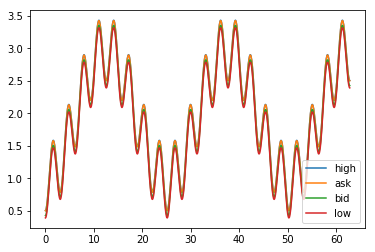

In [8]:
# Simulation of High|Low price prediction and real-time quotes (Bid,Ask)
import matplotlib.pyplot as plt
x = np.linspace(0, 20*np.pi, 1000)
xc = np.linspace(0, 5*np.pi, 1000)
y_ask = 1.5 + ((np.sin(x) * np.sin(x)) - np.cos(xc))
y_bid = y_ask - np.random.random_sample()/10
y_high = y_ask + np.random.random_sample()/10
y_low  = y_bid - np.random.random_sample()/10

plt.plot(x, y_high)
plt.plot(x, y_ask)
plt.plot(x, y_bid)
plt.plot(x, y_low)
plt.legend(['high','ask','bid','low'])

In [9]:
# Callback to get High|Low predictions from sinusoidal signal built before
#######################################################################################
def pull_predicted_data(step):
  return {'high':y_high[step], 'low':y_low[step]}

    
# Callback to get Bid,Ask quotes from sinusoidal signal built before
#######################################################################################
def pull_last_tick(instrument, step):
  return {'ask':y_ask[step], 'bid':y_bid[step]}


# Callback to get 50 random candlestick pattern detectors
#######################################################################################
def pull_last_cdl_patterns(step):
  return np.random.randint(-1, high=2, size=50)

Now, I create and configure the trading environment:

In [10]:
# environment creation
env = TradeSimEnv()

# Environment configuration setup:
# Episode's steps = sinusoidal signal samples
# instrument = Financial instrument descriptive name
# equity = Initial account equity value
# leverage = Leverage used per operation
# commissions = Fixed commissions applied after each operation
# num_cdl_patterns = Number of candlestick pattern detectors
# cb_pull_cdl_patterns = Callback to get candlestick pattern detectors. 
# cb_pull_predictions = Callback to get predictions. 
# cb_pull_ticks = Callback to get quotes. Ej:
# cb_market_info = None (internal emulator will be used)
        
env.configure(steps_per_episode=x.shape[0]-1,      
              instrument = 'EURUSD', 
              equity=10000.0, 
              leverage=1.0, 
              commissions=0.5,
              num_cdl_patterns=50,
              cb_pull_cdl_patterns=pull_last_cdl_patterns,
              cb_pull_predictions=pull_predicted_data, 
              cb_pull_ticks=pull_last_tick,
              cb_market_info=None)


At this point, I can start the environment and execute random actions. At the end I use the stats report to show:

- Step by step rewards
- Accumulated total rewards
- Account's Balance
- Symbols where positions have been opened and closed

Initial observation:
 {'price_high': 0.5053442403864656, 'price_low': 0.3902553980382384, 'tick_ask': 0.5, 'tick_bid': 0.42576804852896066, 'acc_balance': 10000.0, 'acc_floatpl': 0, 'acc_pl': 0, 'pos_long': 0, 'pos_short': 0, 'pos_price': 0, 'pos_sl': 0, 'cdl_patterns': array([ 0,  1, -1, -1,  0,  1,  1,  0,  1,  0,  0, -1, -1, -1,  0,  1,  0,
        0,  1, -1,  0, -1, -1, -1,  0,  0,  0,  0,  1, -1,  0,  1,  0,  0,
       -1, -1,  0,  1,  0, -1, -1,  0, -1, -1, -1,  1,  0, -1,  1,  1])}
Episode End!


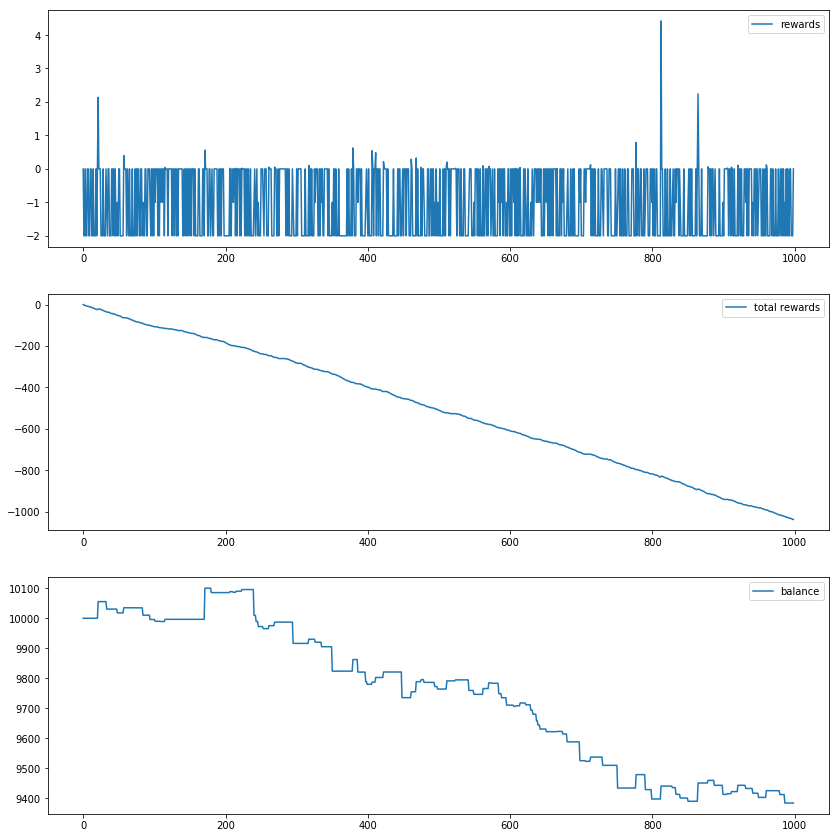

In [11]:
# Initialize environment and check first observation
obs = env.reset()
done = False
print('Initial observation:\r\n', obs)

# until a finish condition...
while not done:
  # generate a random action
  action=env.action_space.sample()
  # and execute it
  state, reward, done, info = env.step(action)
  
# once finished...  
print('Episode End!')

# get episodic statistics
stats = env.statistics()

# Show episode results, step by step:
plt.figure(figsize=(14,20))
# Rewards per step
plt.subplot(4,1,1)
plt.plot(np.asarray(stats['rewards']))
plt.legend(['rewards'])
# Accumulated rewards
plt.subplot(4,1,2)
plt.plot(np.cumsum(np.asarray(stats['rewards'])))
plt.legend(['total rewards'])
# Account balance
plt.subplot(4,1,3)
plt.plot(np.asarray(stats['balances']))
plt.legend(['balance'])



Also, other statistic results can be extrated from the environment. For example:

- ```pos_open_long```: provides a list of flags, step by step, when an open long position is executed.

- ```pos_open_short```: provides a list of flags, step by step, when an open short position is executed.

- ```pos_close```: provides a list of flags, step by step, when any opened position is closed.

With a few code adaption, I can show a chart plotting opening and closing actions with different symbols:

- Open Long: is marked in ```GREEN```
- Open Short: is marked in ```RED```
- Close any: is marked in ```BLACK```


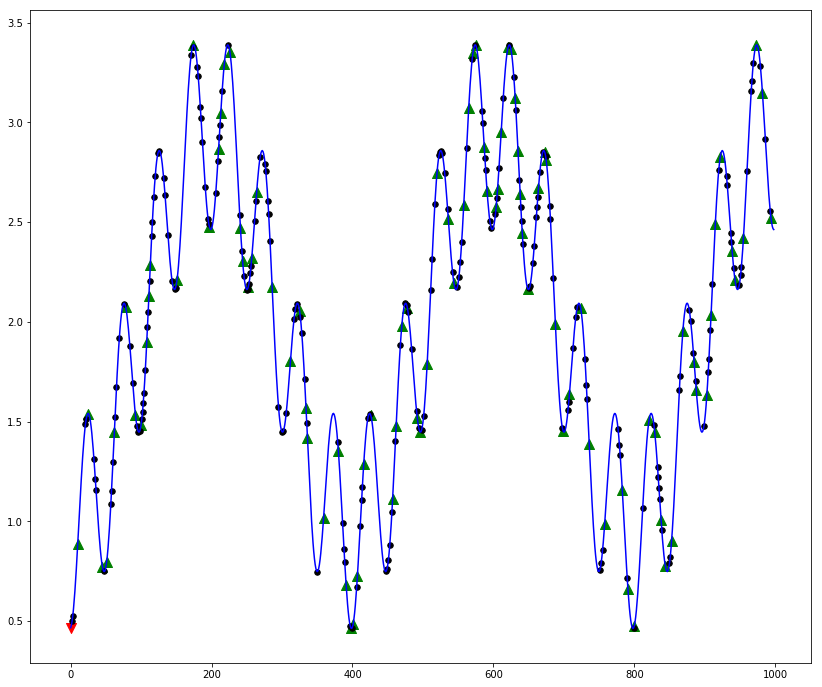

In [14]:
# Get instrument's price along the episode as the mid point between Bid and Ask (first step is discarded as is the initial condition)
price = (y_bid + y_ask)/2
price = price[1:]

# I build arrays with indexes values for opening long|short and closing actions.
x_marker_open_long = np.where(np.asarray(stats['pos_open_long']) > 0)[0]
x_marker_open_short = np.where(np.asarray(stats['pos_open_short']) > 0)[0]
x_marker_close = np.where(np.asarray(stats['pos_close']) > 0)[0]

# From those arrays, I get new ones with opening and closing values.
y_marker_open_long = np.asarray(stats['pos_open_long']) * price[:np.asarray(stats['pos_open_long']).shape[0]]
y_marker_open_short = np.asarray(stats['pos_open_short']) * price[:np.asarray(stats['pos_open_short']).shape[0]]
y_marker_close = np.asarray(stats['pos_close']) * price[:np.asarray(stats['pos_close']).shape[0]]
y_marker_open_long = np.take(y_marker_open_long, x_marker_open_long)
y_marker_open_short = np.take(y_marker_open_short, x_marker_open_short)
y_marker_close = np.take(y_marker_close, x_marker_close)


# Let`s show the results:
plt.figure(figsize=(14,12))
# Show the instrument price along the episode in BLUE
plt.plot(price, color='blue')
# Show markers for opening long operations
plt.scatter(x_marker_open_long, y_marker_open_long, marker='^', color='g', s=100)
# ... for opening short operations
plt.scatter(x_marker_open_short, y_marker_open_short, marker='v', color='r', s=100)
# ... for closing any opened operation
plt.scatter(x_marker_close, y_marker_close, marker='o', color='black', s=30)


## 2. Environment test

Once the Trading Environment has been installed via  `pip install -e .` command, it can be imported with package name `gym_tradesim`.

To execute this second section, reload the kernel and discard the execution of all previous cells.

In [1]:
# After reloading, reimport required libraries
import gym
import gym_tradesim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Show Gym registry and check if EnvSpec(TradeSim-v0)] appears at the end
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v2), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(Hopper-v2), EnvSpec(Swimmer-v2), EnvSpec(Walker2d-v2), EnvSpec(Ant-v2), EnvSpec(Hum

In [3]:
# Environment loading
env = gym.make('TradeSim-v0')

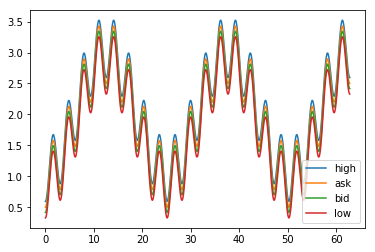

In [4]:
# Again, create simulation series for predictions and real time quotes
x = np.linspace(0, 20*np.pi, 1000)
xc = np.linspace(0, 5*np.pi, 1000)
y_ask = 1.5 + ((np.sin(x) * np.sin(x)) - np.cos(xc))
y_bid = y_ask - np.random.random_sample()/10
y_high = y_ask + np.random.random_sample()/10
y_low  = y_bid - np.random.random_sample()/10

plt.plot(x, y_high)
plt.plot(x, y_ask)
plt.plot(x, y_bid)
plt.plot(x, y_low)
plt.legend(['high','ask','bid','low'])

In [6]:
# Callback to get High|Low predictions from sinusoidal signal built before
#######################################################################################
def pull_predicted_data(step):
  return {'high':y_high[step], 'low':y_low[step]}

    
# Callback to get Bid,Ask quotes from sinusoidal signal built before
#######################################################################################
def pull_last_tick(instrument, step):
  return {'ask':y_ask[step], 'bid':y_bid[step]}


# Callback to get 50 random candlestick pattern detectors
#######################################################################################
def pull_last_cdl_patterns(step):
  return np.random.randint(-1, high=2, size=50)


In [7]:
# Environment configuration by internal method 'configure'
# Episode's steps = sinusoidal signal samples
# instrument = Financial instrument descriptive name
# equity = Initial account equity value
# leverage = Leverage used per operation
# commissions = Fixed commissions applied after each operation
# num_cdl_patterns = Number of candlestick pattern detectors
# cb_pull_cdl_patterns = Callback to get candlestick pattern detectors. 
# cb_pull_predictions = Callback to get predictions. 
# cb_pull_ticks = Callback to get quotes. Ej:
# cb_market_info = None (internal emulator will be used)
        
env.env.configure(steps_per_episode=x.shape[0]-1,      
              instrument = 'EURUSD', 
              equity=10000.0, 
              leverage=1.0, 
              commissions=0.5,
              num_cdl_patterns=50,
              cb_pull_cdl_patterns=pull_last_cdl_patterns,
              cb_pull_predictions=pull_predicted_data, 
              cb_pull_ticks=pull_last_tick,
              cb_market_info=None)

In [8]:
# reset environment and show initial state
obs = env.reset()
obs

{'price_high': 0.5949730341532012,
 'price_low': 0.3282062126500209,
 'tick_ask': 0.5,
 'tick_bid': 0.41715421048009177,
 'acc_balance': 10000.0,
 'acc_floatpl': 0,
 'acc_pl': 0,
 'pos_long': 0,
 'pos_short': 0,
 'pos_price': 0,
 'pos_sl': 0,
 'cdl_patterns': array([ 0,  1, -1,  1,  0, -1, -1,  1,  0, -1,  0,  1, -1,  1,  1,  0, -1,
         0, -1,  0, -1,  1,  1,  0,  1, -1,  1,  0,  0,  0,  1,  1, -1,  1,
        -1,  1,  0, -1,  1,  0,  0,  1,  1,  0,  0,  1, -1,  1, -1,  1])}

Episode End!


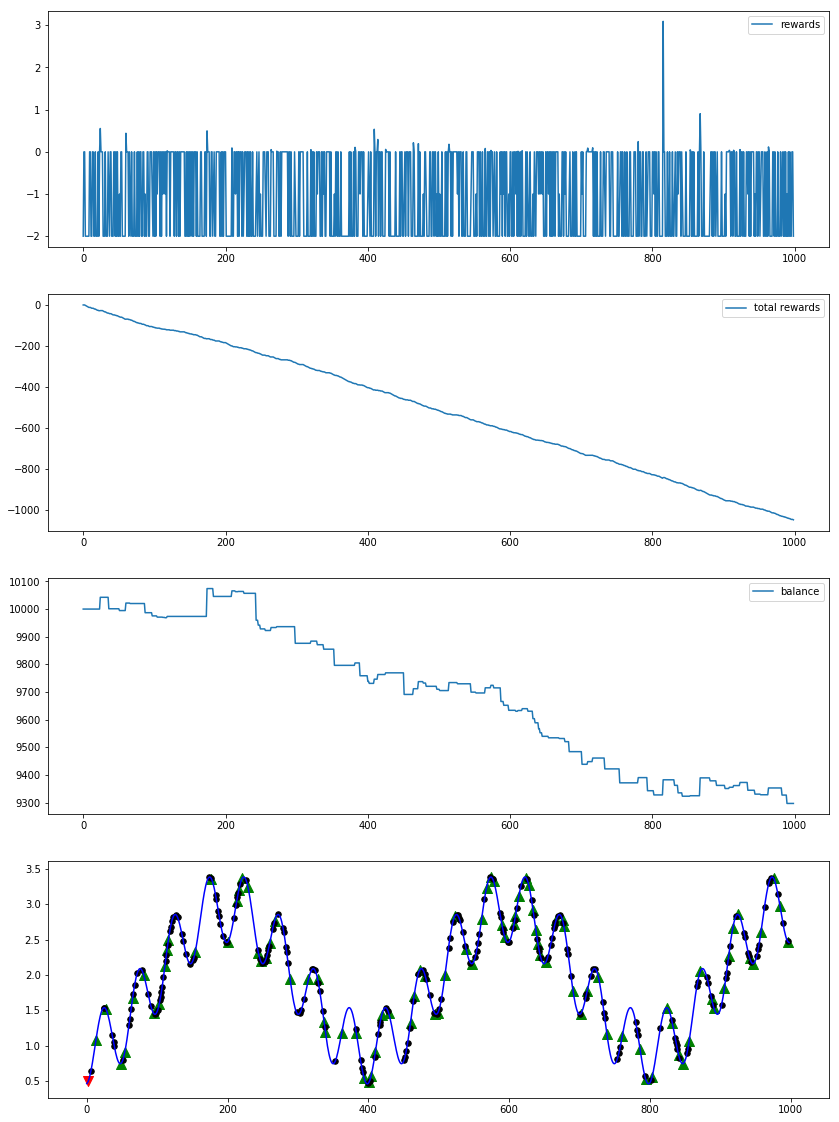

In [9]:
# reset again and execute random actions until the end of the episode
obs = env.reset()
done = False

while not done:
  # execute random action
  action=env.action_space.sample()
  #print('\r\nAction:',action)
  state, reward, done, info = env.step(action)
  #print('\r\nState:',state)
  #print('\r\nReward:',reward)
  #print('\r\nDone:',done)
  #print('\r\nInfo:',info)
  #done = True
  
print('Episode End!')

# get episode stats report
stats = env.env.statistics()

# Visualize stats
plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.plot(np.asarray(stats['rewards']))
plt.legend(['rewards'])
plt.subplot(4,1,2)
plt.plot(np.cumsum(np.asarray(stats['rewards'])))
plt.legend(['total rewards'])
plt.subplot(4,1,3)
plt.plot(np.asarray(stats['balances']))
plt.legend(['balance'])

# Get price as mean of bid-ask (discard initial value at step=0)
price = (y_bid + y_ask)/2
price = price[1:]

# Get arrays with indexes from long, short and close operations
x_marker_open_long = np.where(np.asarray(stats['pos_open_long']) > 0)[0]
x_marker_open_short = np.where(np.asarray(stats['pos_open_short']) > 0)[0]
x_marker_close = np.where(np.asarray(stats['pos_close']) > 0)[0]

# Get array with values from long, short and close operations
y_marker_open_long = np.asarray(stats['pos_open_long']) * price[:np.asarray(stats['pos_open_long']).shape[0]]
y_marker_open_short = np.asarray(stats['pos_open_short']) * price[:np.asarray(stats['pos_open_short']).shape[0]]
y_marker_close = np.asarray(stats['pos_close']) * price[:np.asarray(stats['pos_close']).shape[0]]
y_marker_open_long = np.take(y_marker_open_long, x_marker_open_long)
y_marker_open_short = np.take(y_marker_open_short, x_marker_open_short)
y_marker_close = np.take(y_marker_close, x_marker_close)

plt.subplot(4,1,4)
# visualize price
plt.plot(price, color='blue')
# opening long positions
plt.scatter(x_marker_open_long, y_marker_open_long, marker='^', color='g', s=100)
# opening short positions
plt.scatter(x_marker_open_short, y_marker_open_short, marker='v', color='r', s=100)
# closing positions
plt.scatter(x_marker_close, y_marker_close, marker='o', color='black', s=30)
plt.show()

## Summary

As we've seen along the notebook, following OpenAI Gym API, is quite easy for building Reinforcement Learning environments. At this point, we are ready for Agent development.

See you on next notebook!